Main Disorder Counts:
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64
Secondary Disorder Counts:
specific.disorder
Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behavioral addiction disorder      93
Bipolar disorder                   67
Panic disorder                     59
Posttraumatic stress disorder      52
Social anxiety disorder            48
Obsessive compulsitve disorder     46
Acute stress disorder              38
Adjustment disorder                38
Name: count, dtype: int64


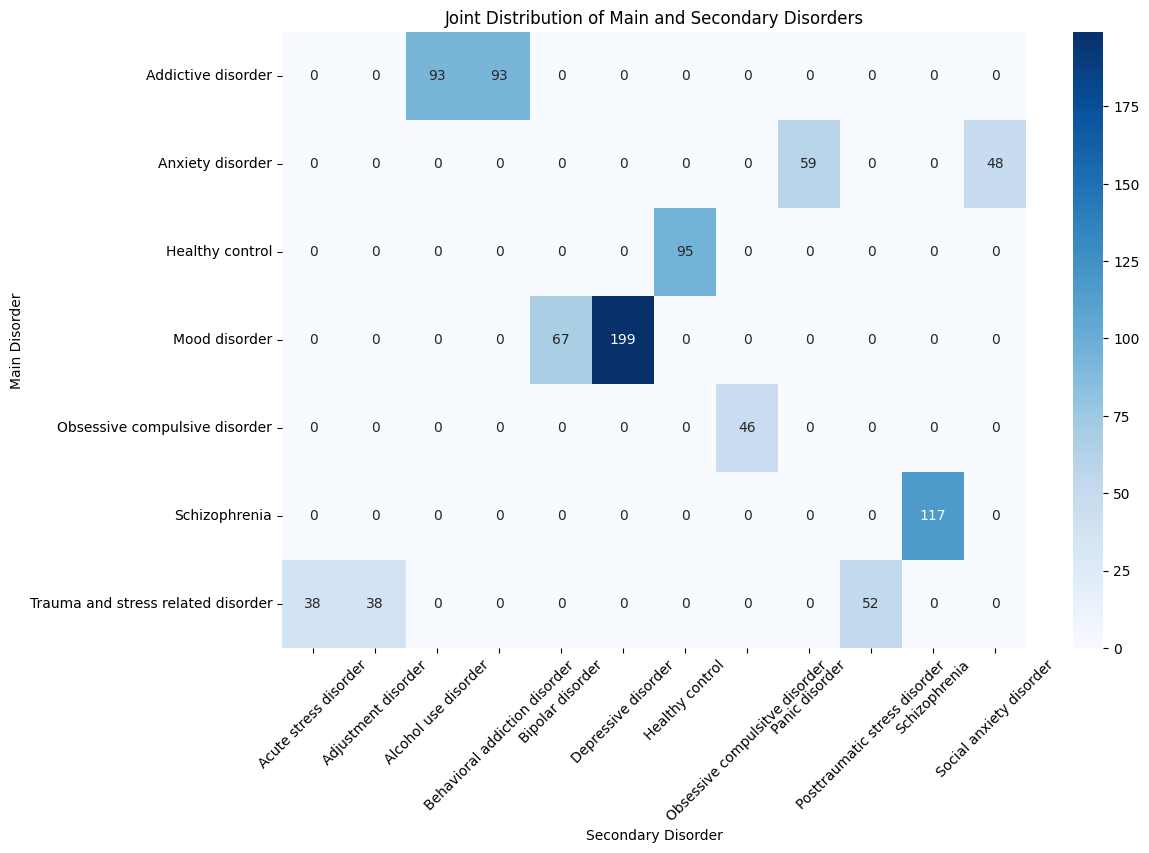

Pairwise Disorder Relationships:
                         main.disorder               specific.disorder  Count
0                        Mood disorder             Depressive disorder    199
1                        Schizophrenia                   Schizophrenia    117
2                      Healthy control                 Healthy control     95
3                   Addictive disorder            Alcohol use disorder     93
4                   Addictive disorder   Behavioral addiction disorder     93
5                        Mood disorder                Bipolar disorder     67
6                     Anxiety disorder                  Panic disorder     59
7   Trauma and stress related disorder   Posttraumatic stress disorder     52
8                     Anxiety disorder         Social anxiety disorder     48
9        Obsessive compulsive disorder  Obsessive compulsitve disorder     46
10  Trauma and stress related disorder           Acute stress disorder     38
11  Trauma and stress related d

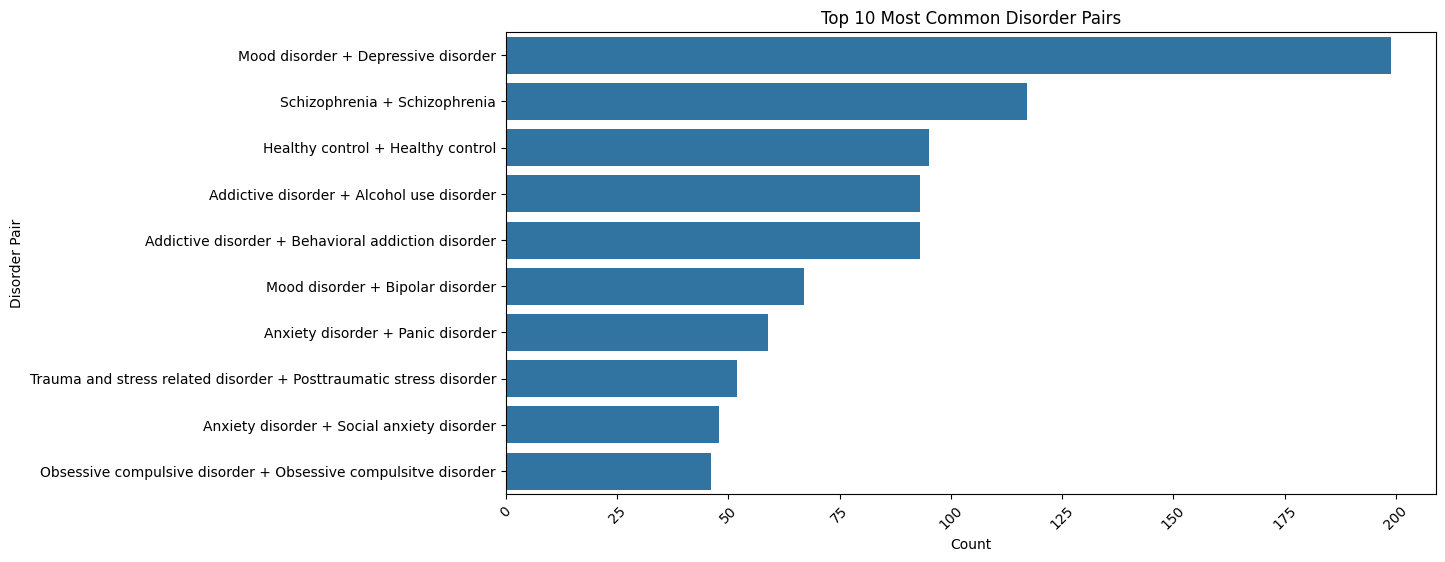

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


# dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
eeg_data = pd.read_csv(file_path)

# check for disorder columns
if 'main.disorder' in eeg_data.columns and 'specific.disorder' in eeg_data.columns:
    main_disorder_col = 'main.disorder'
    secondary_disorder_col = 'specific.disorder'
else:
    raise ValueError("The dataset does not contain 'main disorder' and 'secondary disorder' columns.")

# explore disorder relationships
# count unique values for both main and secondary disorders
main_disorder_counts = eeg_data[main_disorder_col].value_counts()
secondary_disorder_counts = eeg_data[secondary_disorder_col].value_counts()

# display counts
print("Main Disorder Counts:")
print(main_disorder_counts)

print("Secondary Disorder Counts:")
print(secondary_disorder_counts)

# joint distribution of main and secondary disorders
joint_disorder_counts = eeg_data.groupby([main_disorder_col, secondary_disorder_col]).size().unstack(fill_value=0)

# visualise joint distribution as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(joint_disorder_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Joint Distribution of Main and Secondary Disorders")
plt.xlabel("Secondary Disorder")
plt.ylabel("Main Disorder")
plt.xticks(rotation=45)
plt.show()

# pairwise disorder relationships
# check if there are common patterns or correlations between main and secondary disorders
def disorder_relationship_analysis(df, main_col, secondary_col):
    combined_disorders = df[[main_col, secondary_col]].value_counts()
    total_disorders = combined_disorders.reset_index()
    total_disorders.columns = [main_col, secondary_col, 'Count']
    return total_disorders

disorder_relationships = disorder_relationship_analysis(eeg_data, main_disorder_col, secondary_disorder_col)
print("Pairwise Disorder Relationships:")
print(disorder_relationships)

# visualize most common pairings
plt.figure(figsize=(12, 6))
most_common_pairs = disorder_relationships.sort_values(by='Count', ascending=False).head(10)
most_common_pairs['Disorder Pair'] = most_common_pairs[main_disorder_col] + " + " + most_common_pairs[secondary_disorder_col]
sns.barplot(x='Count', y='Disorder Pair', data=most_common_pairs)
plt.title("Top 10 Most Common Disorder Pairs")
plt.xlabel("Count")
plt.ylabel("Disorder Pair")
plt.xticks(rotation=45)
plt.show()


In [2]:
# load dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
data = pd.read_csv(file_path)

metadata_columns = ['sex', 'age', 'education', 'IQ']

condition_columns = ['main.disorder', 'specific.disorder']

time_series_columns = [col for col in data.columns if col.startswith('AB.') or col.startswith('COH.')]

# preprocess conditions
ohe = OneHotEncoder(sparse_output=False)
condition_matrix = ohe.fit_transform(data[condition_columns])

# normalize time-series data
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(data[time_series_columns])

# reshape time-series data
seq_length = len(time_series_columns)  # number of time steps
time_series_data = time_series_data.reshape(-1, seq_length, 1)  # shape: (samples, sequence_length, features)

# split data
X_train, X_test, y_train, y_test = train_test_split(time_series_data, condition_matrix, test_size=0.2, random_state=42)

# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [3]:
time_series_columns = [col for col in data.columns if col.startswith('AB.') or col.startswith('COH.')]
seq_length = len(time_series_columns)
print(f"Sequence Length (Number of Time-Series Columns): {seq_length}")

condition_dim = condition_matrix.shape[1]
print(f"Condition Dimension (Number of One-Hot Encoded Features): {condition_dim}")

print(f"Time-Series Data Shape (Before Reshaping): {data[time_series_columns].shape}")
print(f"Time-Series Data Shape (After Reshaping): {time_series_data.shape}")
print(f"Condition Matrix Shape: {condition_matrix.shape}")
print(f"Training Data Shape: {X_train_tensor.shape}, Training Labels Shape: {y_train_tensor.shape}")
print(f"Test Data Shape: {X_test_tensor.shape}, Test Labels Shape: {y_test_tensor.shape}")

print("Unique Main Disorders:")
print(data['main.disorder'].value_counts())

print("Unique Specific Disorders:")
print(data['specific.disorder'].value_counts())

print("Unique Combined Conditions (Before Encoding):")
print(data.groupby(['main.disorder', 'specific.disorder']).size())

Sequence Length (Number of Time-Series Columns): 1140
Condition Dimension (Number of One-Hot Encoded Features): 19
Time-Series Data Shape (Before Reshaping): (945, 1140)
Time-Series Data Shape (After Reshaping): (945, 1140, 1)
Condition Matrix Shape: (945, 19)
Training Data Shape: torch.Size([756, 1140, 1]), Training Labels Shape: torch.Size([756, 19])
Test Data Shape: torch.Size([189, 1140, 1]), Test Labels Shape: torch.Size([189, 19])
Unique Main Disorders:
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64
Unique Specific Disorders:
specific.disorder
Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behav

Epoch 1, Total Loss: 121.1219, Reconstruction Loss: 120.7688, KL Divergence: 0.7062
Epoch 2, Total Loss: 90.3833, Reconstruction Loss: 89.8055, KL Divergence: 1.1554
Epoch 3, Total Loss: 84.2475, Reconstruction Loss: 83.5316, KL Divergence: 1.4316
Epoch 4, Total Loss: 82.2144, Reconstruction Loss: 81.0183, KL Divergence: 2.3923
Epoch 5, Total Loss: 81.4055, Reconstruction Loss: 80.1295, KL Divergence: 2.5520
Epoch 6, Total Loss: 79.6966, Reconstruction Loss: 78.1665, KL Divergence: 3.0602
Epoch 7, Total Loss: 78.5043, Reconstruction Loss: 76.7097, KL Divergence: 3.5891
Epoch 8, Total Loss: 77.4441, Reconstruction Loss: 74.9560, KL Divergence: 4.9761
Epoch 9, Total Loss: 78.8424, Reconstruction Loss: 77.3377, KL Divergence: 3.0093
Epoch 10, Total Loss: 76.2910, Reconstruction Loss: 74.2667, KL Divergence: 4.0486
Epoch 11, Total Loss: 76.5871, Reconstruction Loss: 74.9841, KL Divergence: 3.2059
Epoch 12, Total Loss: 76.1442, Reconstruction Loss: 74.2995, KL Divergence: 3.6894
Epoch 13, T

<ipython-input-4-ee2e54fb1b56>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)


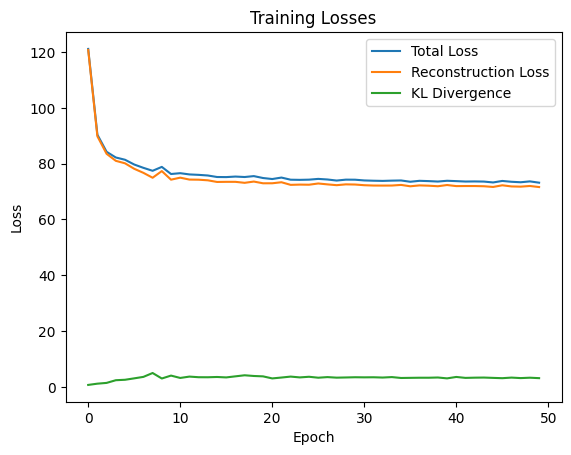

In [4]:
# define the Time-Series CVAE Model
class TimeSeriesCVAE(nn.Module):
    def __init__(self, seq_length, condition_dim, latent_dim):
        super(TimeSeriesCVAE, self).__init__()

        self.hidden_size = 64

        # encoder
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.encoder_dropout = nn.Dropout(0.2)

        # decoder
        self.decoder_lstm = nn.LSTM(input_size=latent_dim + condition_dim, hidden_size=self.hidden_size, batch_first=True)
        self.decoder_output = nn.Linear(self.hidden_size, 1)
        self.decoder_dropout = nn.Dropout(0.2)

    def encode(self, x, c):
        _, (h, _) = self.encoder_lstm(x)  # h: (1, batch_size, hidden_size)
        h = h.squeeze(0)
        h = self.encoder_dropout(h)
        h = torch.cat([h, c], dim=1)  # concatenate condition vector
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)  # repeat latent vector for each time step
        c = c.unsqueeze(1).repeat(1, seq_length, 1)  # repeat condition vector for each time step
        zc = torch.cat([z, c], dim=2)  # shape: (batch_size, seq_length, latent_dim + condition_dim)
        output, _ = self.decoder_lstm(zc)
        output = self.decoder_dropout(output)
        return self.decoder_output(output)  # shape: (batch_size, seq_length, 1)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, x.size(1)), mu, logvar

# loss function for CVAE with KL Divergence Scaling (Beta-VAE)
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence, recon_loss, kl_divergence

# train the CVAE
seq_length = 1140
condition_dim = 19
latent_dim = 64

cvae = TimeSeriesCVAE(seq_length, condition_dim, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Tracking losses
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0

    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)
        loss, recon_loss, kl_loss = cvae_loss(recon_x, x, mu, logvar, beta=0.5)  # Adjust beta as needed
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()

    scheduler.step()

    # log epoch losses
    train_loss_history.append(train_loss / len(train_loader.dataset))
    recon_loss_history.append(recon_loss_total / len(train_loader.dataset))
    kl_loss_history.append(kl_loss_total / len(train_loader.dataset))

    print(f"Epoch {epoch+1}, Total Loss: {train_loss / len(train_loader.dataset):.4f}, "
          f"Reconstruction Loss: {recon_loss_total / len(train_loader.dataset):.4f}, "
          f"KL Divergence: {kl_loss_total / len(train_loader.dataset):.4f}")

print("Time-Series CVAE training complete.")

# generate conditioned Time-Series samples
def generate_samples(model, condition, seq_length, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        c = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)
        generated = model.decode(z, c, seq_length).cpu().numpy()
    return generated

# generate samples for a specific condition
sample_condition = y_train_tensor[0]  # use a sample condition
generated_samples = generate_samples(cvae, sample_condition, seq_length, num_samples=5)
print("Generated Time-Series Samples:")

# plot Training Losses
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


In [5]:
# function to compute metrics
def compute_metrics_timeseries_cvae(model, data_loader, device, beta=1.0):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    all_original = []
    all_reconstructed = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            recon_x, mu, logvar = model(x, c)

            # compute losses
            recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + beta * kl_loss

            # store results
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            all_original.append(x.cpu().numpy())
            all_reconstructed.append(recon_x.cpu().numpy())

    # flatten arrays for metrics
    all_original = np.concatenate(all_original)
    all_reconstructed = np.concatenate(all_reconstructed)

    # compute additional metrics
    mae = np.mean(np.abs(all_original - all_reconstructed))
    r2 = 1 - np.sum((all_original - all_reconstructed)**2) / np.sum((all_original - np.mean(all_original))**2)

    return {
        "Total Loss": total_loss / len(data_loader.dataset),
        "Reconstruction Loss": total_recon_loss / len(data_loader.dataset),
        "KL Divergence": total_kl_loss / len(data_loader.dataset),
        "MAE": mae,
        "R²": r2
    }


metrics = compute_metrics_timeseries_cvae(cvae, test_loader, device)
print(metrics)


{'Total Loss': 74.99515335648148, 'Reconstruction Loss': 72.05904069527116, 'KL Divergence': 2.936112338272983, 'MAE': 0.2129375, 'R²': 0.07225143909454346}


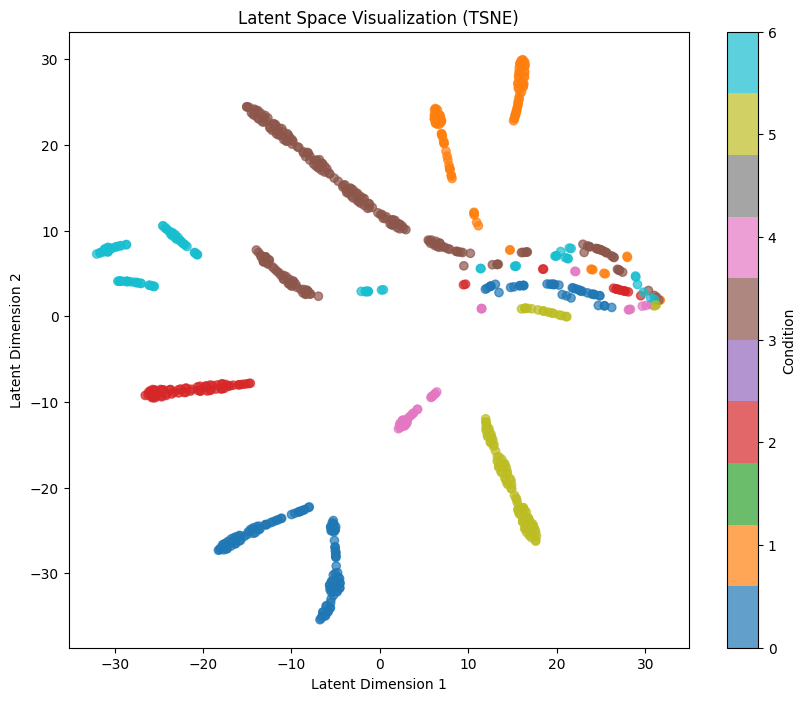

In [6]:
def visualize_latent_space(model, data_loader, condition_labels, reduction_method='tsne'):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            mu, _ = model.encode(x, c)  # Get latent space means
            latent_vectors.append(mu.cpu().numpy())
            labels.append(c.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # dimensionality reduction
    if reduction_method == 'tsne':
        reduced_latents = TSNE(n_components=2).fit_transform(latent_vectors)
    elif reduction_method == 'pca':
        reduced_latents = PCA(n_components=2).fit_transform(latent_vectors)
    else:
        raise ValueError("Invalid reduction_method. Choose 'tsne' or 'pca'.")

    # plot the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_latents[:, 0],
        reduced_latents[:, 1],
        c=np.argmax(labels, axis=1),
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label="Condition")
    plt.title(f"Latent Space Visualization ({reduction_method.upper()})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

visualize_latent_space(cvae, train_loader, y_train, reduction_method='tsne')

In [7]:
def compute_dci(latent_vectors, labels):

    num_latent_dims = latent_vectors.shape[1]
    num_factors = labels.shape[1]

    importance_matrix = np.zeros((num_latent_dims, num_factors))
    informativeness_scores = []

    for i in range(num_factors):
        # train a logistic regression model for each factor
        factor_labels = labels[:, i]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_vectors, factor_labels)

        # record importance scores (coefficients)
        importance_matrix[:, i] = np.abs(model.coef_).mean(axis=0)

        # compute informativeness (accuracy)
        predictions = model.predict(latent_vectors)
        informativeness_scores.append(accuracy_score(factor_labels, predictions))

    # normalize importance matrix
    importance_matrix /= importance_matrix.sum(axis=0, keepdims=True)

    # disentanglement
    disentanglement_scores = 1.0 - importance_matrix.var(axis=1)
    disentanglement = disentanglement_scores.mean()

    # completeness
    completeness_scores = 1.0 - importance_matrix.var(axis=0)
    completeness = completeness_scores.mean()

    # informativeness
    informativeness = np.mean(informativeness_scores)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }

cvae.eval()
latent_vectors = []
labels = []

# extract latent representations and labels
with torch.no_grad():
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        mu, _ = cvae.encode(x, c)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(c.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# compute DCI metrics
dci_metrics = compute_dci(latent_vectors, labels)
print("DCI Metrics:", dci_metrics)


DCI Metrics: {'disentanglement': 0.9998879625990946, 'completeness': 0.9998780245828321, 'informativeness': 0.9998607630186577}


In [8]:
actual_samples = []
reconstructed_samples = []

cvae.eval()  # set the model to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        recon_x, _, _ = cvae(x, c)

        # save a subset of actual and reconstructed samples
        actual_samples.append(x[:5].cpu().numpy())  # first 5 samples in the batch
        reconstructed_samples.append(recon_x[:5].cpu().numpy())
        break  # only process the first batch for visualisation


In [9]:
# convert lists to NumPy arrays for easier plotting
actual_samples = np.concatenate(actual_samples, axis=0)  # shape: (num_samples, seq_length, 1)
reconstructed_samples = np.concatenate(reconstructed_samples, axis=0)  # same shape as actual_samples

# reshape for plotting
actual_samples = actual_samples.squeeze(-1)  # shape: (num_samples, seq_length)
reconstructed_samples = reconstructed_samples.squeeze(-1)  # same shape as actual_samples


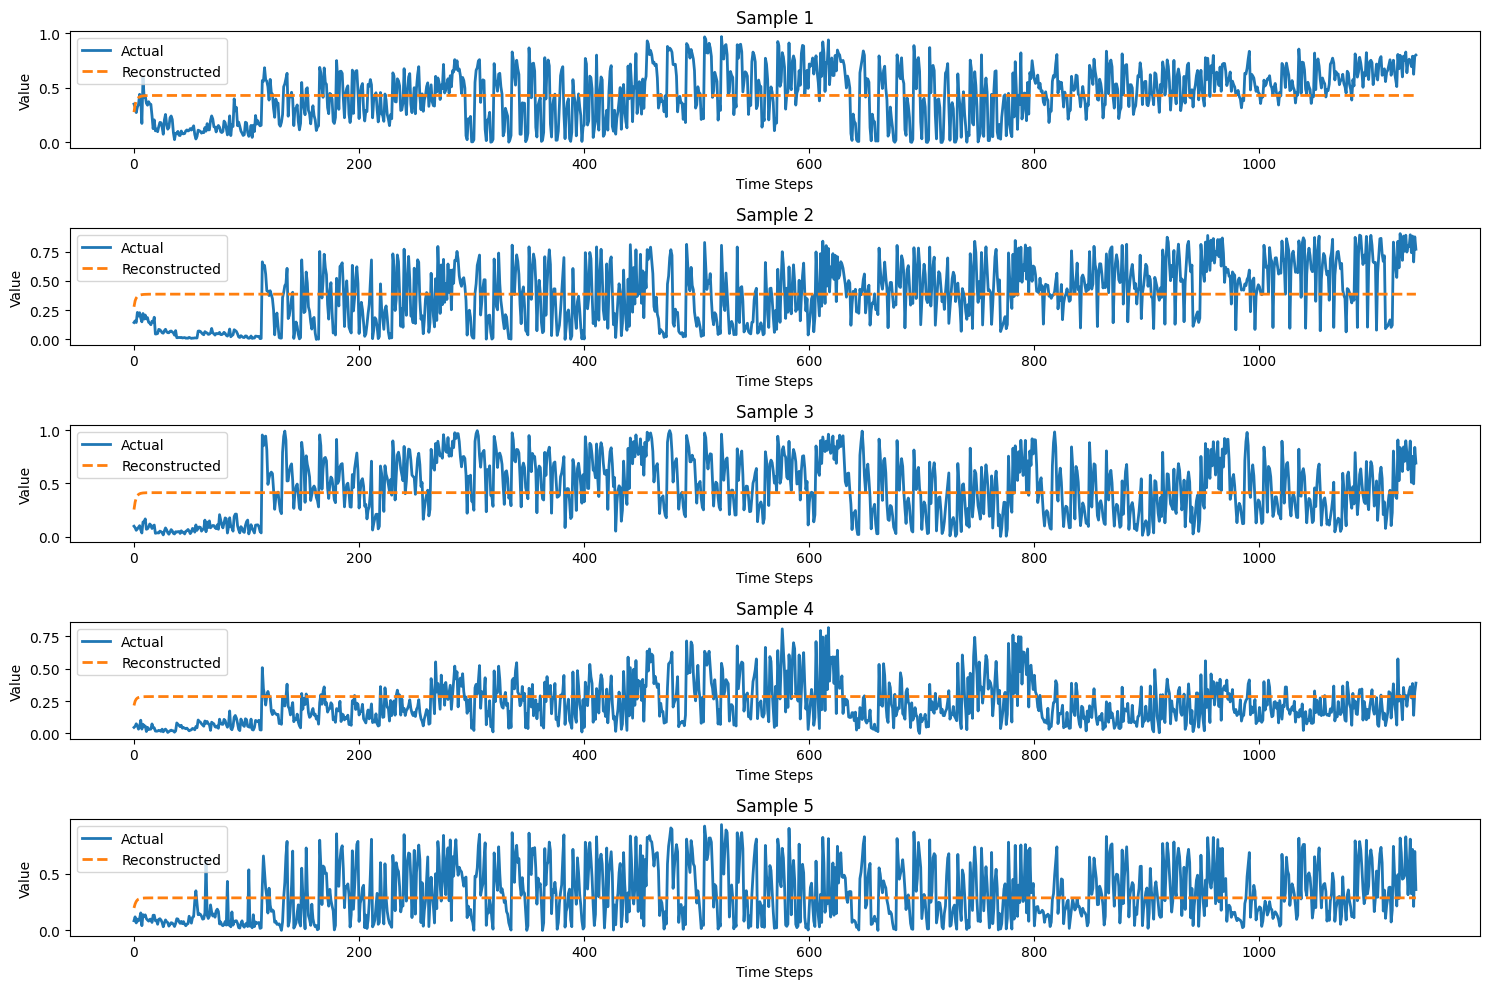

In [10]:
# number of samples to visualize
num_samples_to_plot = 5

plt.figure(figsize=(15, 10))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(actual_samples[i], label='Actual', linestyle='-', linewidth=2)
    plt.plot(reconstructed_samples[i], label='Reconstructed', linestyle='--', linewidth=2)
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()
